In [39]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from typing import Optional, Tuple, Union


In [40]:
import sys
sys.path.append('..')


In [41]:
from dem.energies.gmm_energy import GMM

In [42]:
gmm_dist=GMM(
        plotting_buffer_sample_size=1000,
        should_unnormalize=False,
        data_normalization_factor=1,
        train_set_size=1000,
        test_set_size=1000,
        val_set_size=1000)

In [43]:
true_samples=gmm_dist.gmm.sample((1000,))

ground truth vs itself

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


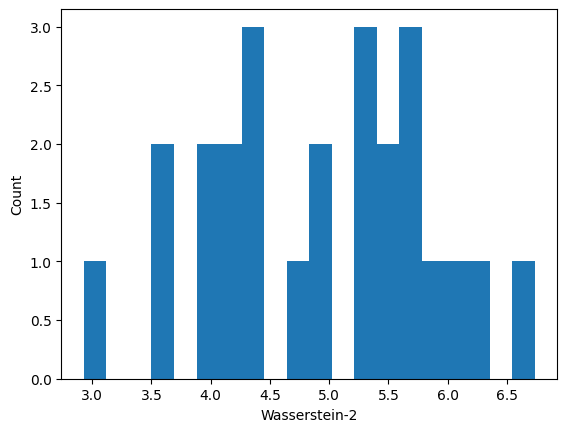

w2 mean 4.908106689172625 w2 std 0.9280212526911796


In [44]:
from dem.models.components.distribution_distances import compute_distribution_distances
w2_list=[]
true_samples=true_samples.unsqueeze(1)
for i in tqdm.tqdm(range(25)):
    new_samples=gmm_dist.gmm.sample((1000,))
    new_samples=new_samples.unsqueeze(1)
    metrics=compute_distribution_distances(true_samples,new_samples,gmm_dist)
    w2=metrics[1][1]
    w2_list.append(w2)

plt.figure()
plt.hist(w2_list,label='Wasserstein-2',bins=20)
plt.ylabel('Count')
plt.xlabel('Wasserstein-2')
plt.show()
print('w2 mean',np.mean(w2_list),'w2 std',np.std(w2_list))


ground truth vs mcmc

In [45]:
w2_list=[]
for i in range(1,6):
    endpoint_name='../gmm_endpoint{}.npy'.format(i)
    torch_endpoint_samples=torch.tensor(np.load(endpoint_name))
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),true_samples.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        current_samples=current_samples.unsqueeze(1)
        metrics=compute_distribution_distances(true_samples,current_samples,gmm_dist)
        w2=metrics[1][1]
        w2_list.append(w2)
print('w2 mean',np.mean(w2_list),'w2 std',np.std(w2_list))

w2 mean 4.628655412416176 w2 std 0.8734011913136229


ground truth vs IDEM

In [46]:
w2_list=[]
for i in range(1,6):
    endpoint_name='../IDEM_samples/GMM_{}_samples_100000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint_name,map_location='cpu')
    torch_endpoint_samples=torch_endpoint_samples*50
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),true_samples.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        current_samples=current_samples.unsqueeze(1)
        metrics=compute_distribution_distances(true_samples,current_samples,gmm_dist)
        w2=metrics[1][1]
        w2_list.append(w2)
print('w2 mean',np.mean(w2_list),'w2 std',np.std(w2_list))

/tmp/ipykernel_2498598/385115577.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint_name,map_location='cpu')


w2 mean 7.431703346148104 w2 std 1.6301630157057745


ground truth vs IEFM

In [47]:
w2_list=[]
for i in range(1,6):
    endpoint_name='../IEFM_samples/GMM_{}_samples_100000.pt'.format(i)
    torch_endpoint_samples=torch.load(endpoint_name,map_location='cpu')
    torch_endpoint_samples=torch_endpoint_samples
    for j in range(5):
        current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),true_samples.shape[0], replacement=False)
        current_samples=torch_endpoint_samples[current_samples_idx]
        current_samples=current_samples.unsqueeze(1)
        metrics=compute_distribution_distances(true_samples,current_samples,gmm_dist)
        w2=metrics[1][1]
        w2_list.append(w2)
print('w2 mean',np.mean(w2_list),'w2 std',np.std(w2_list))

/tmp/ipykernel_2498598/2992397369.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load(endpoint_name,map_location='cpu')


w2 mean 7.115335233410583 w2 std 0.8052596934399275


Generated samples from ground truth, MCMC, IDEM, IEFM

In [48]:
from fab.target_distributions import gmm
from fab.utils.plotting import plot_contours, plot_marginal_pair
import itertools
from dem.utils.logging_utils import fig_to_image

In [66]:
def plot_contours(log_prob_func,
                  ax: Optional[plt.Axes] = None,
                  bounds: Tuple[float, float] = (-5.0, 5.0),
                  grid_width_n_points: int = 20,
                  n_contour_levels: Optional[int] = None,
                  log_prob_min: float = -1000.0):
    """Plot contours of a log_prob_func that is defined on 2D"""
    if ax is None:
        fig, ax = plt.subplots(1)
    x_points_dim1 = torch.linspace(bounds[0], bounds[1], grid_width_n_points)
    x_points_dim2 = x_points_dim1
    x_points = torch.tensor(list(itertools.product(x_points_dim1, x_points_dim2)))
    log_p_x = log_prob_func(x_points).detach()
    log_p_x = torch.clamp_min(log_p_x, log_prob_min)
    log_p_x = log_p_x.reshape((grid_width_n_points, grid_width_n_points))
    x_points_dim1 = x_points[:, 0].reshape((grid_width_n_points, grid_width_n_points)).numpy()
    x_points_dim2 = x_points[:, 1].reshape((grid_width_n_points, grid_width_n_points)).numpy()
    if n_contour_levels:
        c=ax.contour(x_points_dim1, x_points_dim2, log_p_x, levels=n_contour_levels)
    else:
        c=ax.contour(x_points_dim1, x_points_dim2, log_p_x)
    return c


def plot_marginal_pair(samples: torch.Tensor,
                  ax: Optional[plt.Axes] = None,
                  marginal_dims: Tuple[int, int] = (0, 1),
                  bounds: Tuple[float, float] = (-5.0, 5.0),
                  alpha: float = 0.5,color: str = 'blue'):
    """Plot samples from marginal of distribution for a given pair of dimensions."""
    if not ax:
        fig, ax = plt.subplots(1)
    samples = torch.clamp(samples, bounds[0], bounds[1])
    samples = samples.cpu().detach()
    ax.plot(samples[:, marginal_dims[0]], samples[:, marginal_dims[1]], "o", alpha=alpha,color=color)



In [64]:
def plot_samples(samples,color,name):
    plotting_bounds=(-1.4 * 40, 1.4 * 40)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    plot_contours(
    gmm_dist,
    bounds=plotting_bounds,
    ax=ax,
    n_contour_levels=50,
    grid_width_n_points=200,
    )

    plot_marginal_pair(samples, ax=ax, bounds=plotting_bounds,color=color)
    ax.set_title(f"{name}", fontsize=20)
    return fig_to_image(fig)


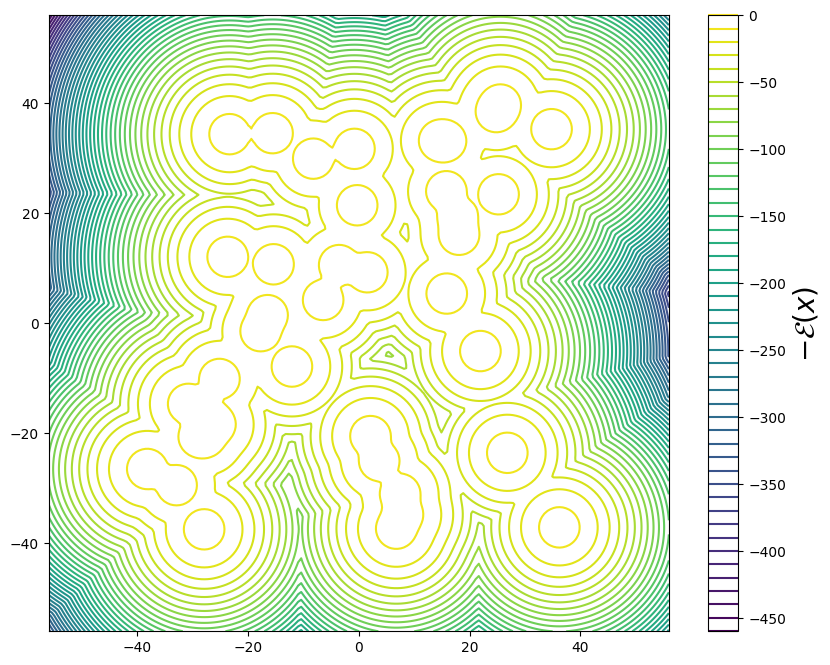

In [80]:
plotting_bounds=(-1.4 * 40, 1.4 * 40)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
c=plot_contours(
    gmm_dist,
    bounds=plotting_bounds,
    ax=ax,
    n_contour_levels=50,
    grid_width_n_points=200,
    )
#increase fontsize
cbar=fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel(r'$-\mathcal{E}(x)$', fontsize=20)
figure=fig_to_image(fig)
figure.save('gmm_contour.png')

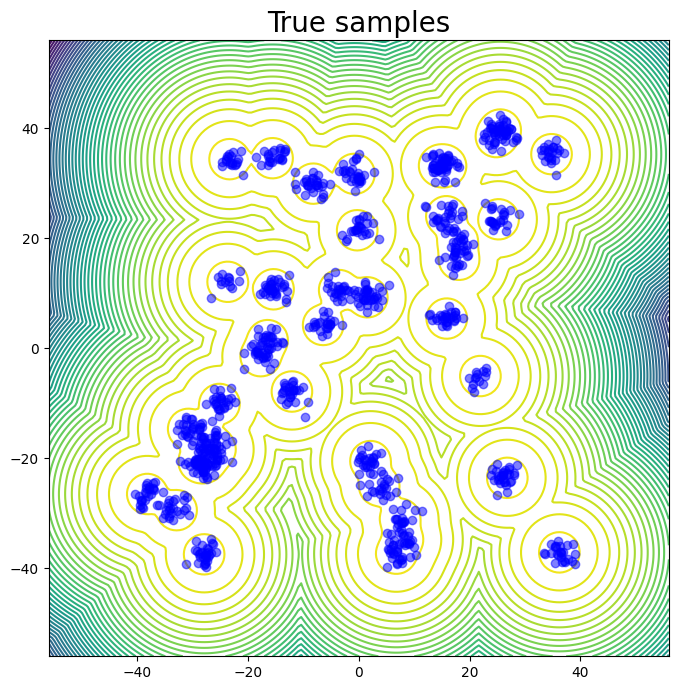

In [ ]:
fig=plot_samples(true_samples[:,0,:],'blue','GMMsamples')
#save the figure
fig.save('true_gmm_samples.png')

/tmp/ipykernel_3348339/2016953748.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load('../IDEM_samples/GMM_1_samples_100000.pt',map_locatio

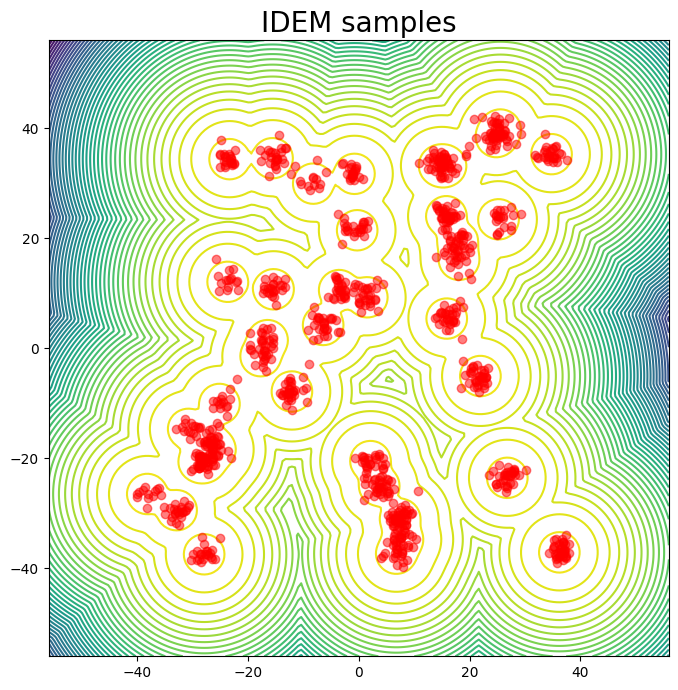

In [14]:
torch_endpoint_samples=torch.load('../IDEM_samples/GMM_1_samples_100000.pt',map_location='cpu')
torch_endpoint_samples=torch_endpoint_samples*50
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),true_samples.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
fig=plot_samples(current_samples,'red','IDEM samples')
fig.save('IDEM_gmm_samples.png')

/tmp/ipykernel_3348339/3002088267.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_endpoint_samples=torch.load('../IEFM_samples/GMM_2_samples_100000.pt',map_locatio

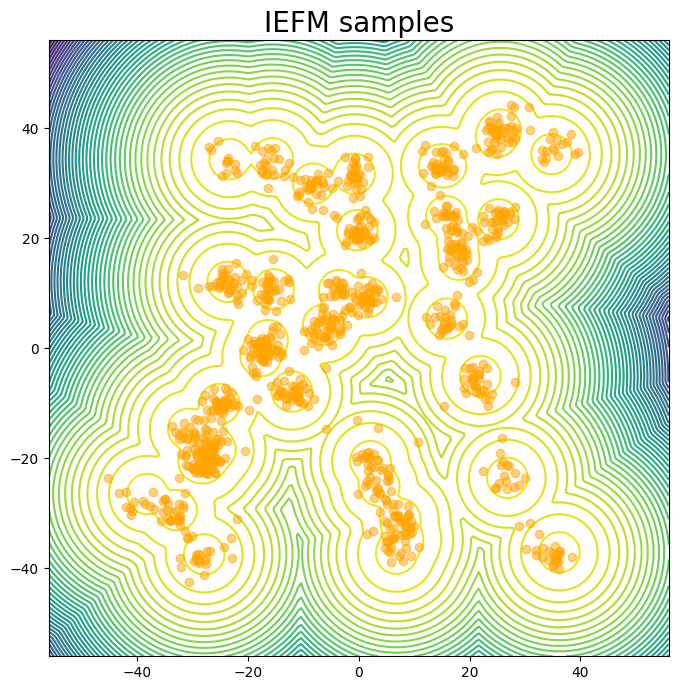

In [15]:
torch_endpoint_samples=torch.load('../IEFM_samples/GMM_2_samples_100000.pt',map_location='cpu')
torch_endpoint_samples=torch_endpoint_samples
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),true_samples.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
fig=plot_samples(current_samples,'orange','IEFM samples')
fig.save('IEFM_gmm_samples.png')

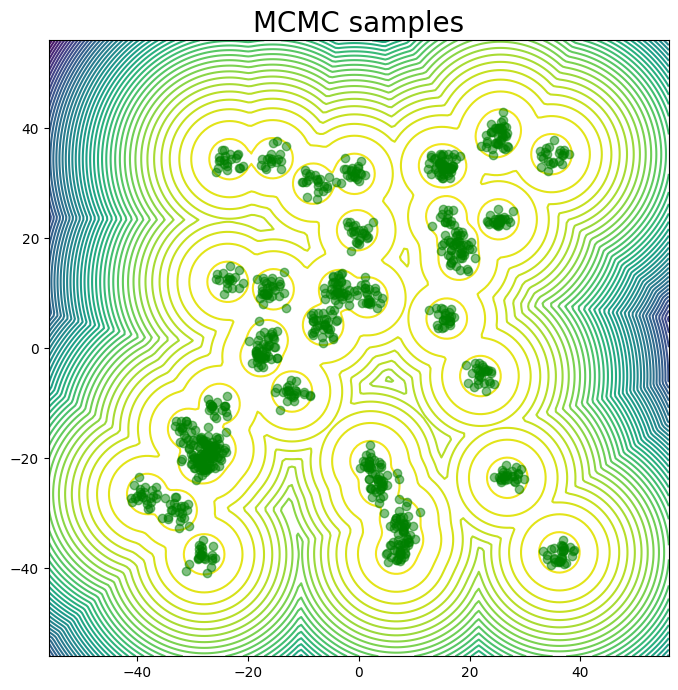

In [16]:
endpoint_name='../gmm_endpoint{}.npy'.format(1)
torch_endpoint_samples=torch.tensor(np.load(endpoint_name))
current_samples_idx=torch.multinomial(torch.ones(torch_endpoint_samples.shape[0]),true_samples.shape[0], replacement=False)
current_samples=torch_endpoint_samples[current_samples_idx]
fig=plot_samples(current_samples,'green','MCMC samples')
fig.save('MCMC_gmm_samples.png')